In [1]:
!pip install torchmetrics
!pip install albumentations
!pip install segmentation_models_pytorch
!pip install timm
!pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=d43fb1d84e9ed40255bc4ea9f3ab9d5671911b736011471239b8f93ad3a1cb04
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=ea143727a7b5e434b2975cda0a4d241a88762829d256838

In [2]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import torch
import torchmetrics
import pandas as pd
import torch.nn as nn
import timm
import segmentation_models_pytorch as smp
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2 # np.array -> torch.Tensor
from torchmetrics import Dice, JaccardIndex
from tqdm import tqdm

In [3]:
!gdown 17sUo2dLcwgPdO_fD4ySiS_4BVzc3wvwA -O Kvasir_SEG_Training_880.zip
!gdown 1O5qAyKrQ8LP8nKQ1dKO-MlMGWbNlRMhx -O Kvasir_SEG_Validation_120.zip
!unzip Kvasir_SEG_Training_880.zip
!unzip Kvasir_SEG_Validation_120.zip

Downloading...
From: https://drive.google.com/uc?id=17sUo2dLcwgPdO_fD4ySiS_4BVzc3wvwA
To: /content/Kvasir_SEG_Training_880.zip
100% 38.1M/38.1M [00:00<00:00, 212MB/s]
Downloading...
From: https://drive.google.com/uc?id=1O5qAyKrQ8LP8nKQ1dKO-MlMGWbNlRMhx
To: /content/Kvasir_SEG_Validation_120.zip
100% 8.14M/8.14M [00:00<00:00, 101MB/s]
Archive:  Kvasir_SEG_Training_880.zip
   creating: Kvasir_SEG_Training_880/
   creating: Kvasir_SEG_Training_880/image/
  inflating: Kvasir_SEG_Training_880/image/cju0qkwl35piu0993l0dewei2.png  
  inflating: Kvasir_SEG_Training_880/image/cju0qoxqj9q6s0835b43399p4.png  
  inflating: Kvasir_SEG_Training_880/image/cju0qx73cjw570799j4n5cjze.png  
  inflating: Kvasir_SEG_Training_880/image/cju0roawvklrq0799vmjorwfv.png  
  inflating: Kvasir_SEG_Training_880/image/cju0rx1idathl0835detmsp84.png  
  inflating: Kvasir_SEG_Training_880/image/cju0s2a9ekvms080138tjjpxr.png  
  inflating: Kvasir_SEG_Training_880/image/cju171py4qiha0835u8sl59ds.png  
  inflating: Kvasir

In [4]:
IMG_SIZE = 256
DEVICE = 'cuda'
BATCH = 32
EPOCHS = 30
N_WORKERS = os.cpu_count()

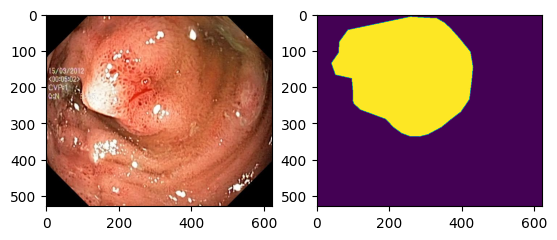

In [5]:
image_path = "/content/Kvasir_SEG_Training_880/image/cju0qkwl35piu0993l0dewei2.png"
mask_path = "/content/Kvasir_SEG_Training_880/mask/cju0qkwl35piu0993l0dewei2.png"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask)

In [6]:
# !rm -r Kvasir_SEG_Validation_120
# !rm -r Kvasir_SEG_Training_880

In [7]:
train_transform = A.Compose([
    A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, min_holes=8),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=IMG_SIZE, height=IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

In [8]:
class UnNormalize(object):
  def __init__(self, mean, std):
    self.mean = mean
    self.std = std

  def __call__(self, tensor):
    """
    Args:
      tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
    Returns:
      Tensor: Normalized image.
    """
    for t, m, s in zip(tensor, self.mean, self.std):
      t.mul_(s).add_(m)
      # The normalize code -> t.sub_(m).div_(s)
    return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [9]:
class PolypsDataset(Dataset):
  def __init__(self, dataset_path, transform=None):
    super().__init__()
    self.dataset_path = dataset_path
    self.transform = transform
    self.df = pd.DataFrame()

    images = os.listdir(os.path.join(self.dataset_path, 'image'))
    masks = os.listdir(os.path.join(self.dataset_path, 'mask'))

    self.df['image'] = [self.dataset_path + 'image/' + image for image in images]
    self.df['mask'] = [self.dataset_path + 'mask/' + mask for mask in masks]

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    image_path = self.df['image'][idx]
    mask_path = self.df['mask'][idx]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask[mask / 255 < 0.5] = 0
    mask[mask / 255 >= 0.5] = 1

    if self.transform is not None:
      transformed = self.transform(image=image, mask=mask)
      transformed_image = transformed['image']
      transformed_mask = transformed['mask']

      return transformed_image, transformed_mask

    return image, mask

In [10]:
train_dataset = PolypsDataset('/content/Kvasir_SEG_Training_880/', train_transform)
test_dataset = PolypsDataset('/content/Kvasir_SEG_Validation_120/', test_transform)

In [11]:
trainloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=N_WORKERS)
testloader = DataLoader(test_dataset, batch_size=BATCH, num_workers=N_WORKERS)

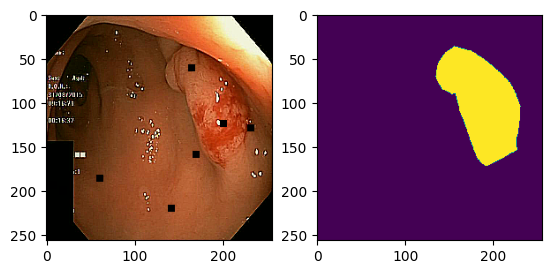

In [12]:
idx = random.randint(0, 100)
image, mask = train_dataset[idx]

plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)

In [31]:
def unet_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, 1, 1),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, 3, 1, 1),
      nn.ReLU(),
  )

class UNet(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.downsample = nn.MaxPool2d(2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    self.backbone = timm.create_model('resnet152', pretrained=True, features_only=True)
    self.block_neck = unet_block(2048, 1024)
    self.block_up1 = unet_block(1024 + 1024, 512)
    self.block_up2 = unet_block(512 + 512, 256)
    self.block_up3 = unet_block(256 + 256, 128)
    self.block_up4 = unet_block(128 + 64, 64)
    self.conv_cls = nn.Conv2d(64, self.n_classes, 1)

  def forward(self, x):
    x1, x2, x3, x4, x5 = self.backbone(x)
    x = self.block_neck(x5)
    x = torch.cat([x4, self.upsample(x)], dim=1)
    x = self.block_up1(x)
    x = torch.cat([x3, self.upsample(x)], dim=1)
    x = self.block_up2(x)
    x = torch.cat([x2, self.upsample(x)], dim=1)
    x = self.block_up3(x)
    x = torch.cat([x1, self.upsample(x)], dim=1)
    x = self.block_up4(x)
    x = self.conv_cls(x)
    x = self.upsample(x)

    return x


In [32]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [33]:
def accuracy_fn(pred, target):
  pred_flat = pred.flatten()
  target_flat = target.flatten()
  acc = torch.sum(pred_flat == target_flat)

  return acc / len(pred)

In [34]:
model = UNet(1).to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

dice_fn = torchmetrics.Dice(num_classes=2, average='macro').to(DEVICE)
iou_fn = torchmetrics.JaccardIndex(num_classes=2, task='binary', average='macro').to(DEVICE)

acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

for ep in range(1, EPOCHS + 1):
  acc_meter.reset()
  train_loss_meter.reset()
  dice_meter.reset()
  iou_meter.reset()
  model.train()

  for batch, (x, y) in enumerate(tqdm(trainloader), start=1):
    optimizer.zero_grad()
    n = x.shape[0]
    x = x.to(DEVICE).float()
    y = y.to(DEVICE).float()
    y_hat = model(x)
    y_hat = y_hat.squeeze()
    loss = criterion(y_hat, y)
    loss.backward()
    optimizer.step()

    with torch.no_grad():

      y_hat_mask = y_hat.sigmoid().round().long()
      dice_score = dice_fn(y_hat_mask, y.long())
      iou_score = iou_fn(y_hat_mask, y.long())
      acc_score = accuracy_fn(y_hat_mask, y.long())

      train_loss_meter.update(loss.item(), n)
      iou_meter.update(iou_score.item(), n)
      dice_meter.update(dice_score.item(), n)
      acc_meter.update(acc_score.item(), n)

  print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
      ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
  ))
  if ep >= 25:
      torch.save(model.state_dict(), "/content/model_ep_{}.pth".format(ep))

100%|██████████| 28/28 [00:38<00:00,  1.36s/it]


EP 1, train loss = 207.21505126953124, accuracy = 25671.707954545454, IoU = 0.19013550931757148, dice = 0.3590286005627025


100%|██████████| 28/28 [00:38<00:00,  1.36s/it]


EP 2, train loss = 201.03378573330966, accuracy = 22204.875, IoU = 0.19857470989227294, dice = 0.31994118311188435


100%|██████████| 28/28 [00:36<00:00,  1.32s/it]


EP 3, train loss = 198.61532759232955, accuracy = 36728.8375, IoU = 0.2682145275852897, dice = 0.5279976162043485


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 4, train loss = 197.2706659490412, accuracy = 44093.43295454545, IoU = 0.32535836154764347, dice = 0.6215979435227134


100%|██████████| 28/28 [00:37<00:00,  1.32s/it]


EP 5, train loss = 196.52478304776278, accuracy = 38939.47840909091, IoU = 0.2832886059175838, dice = 0.558085462180051


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


EP 6, train loss = 195.3156366521662, accuracy = 47862.19090909091, IoU = 0.3714732533151453, dice = 0.672145507552407


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 7, train loss = 194.7845947265625, accuracy = 49050.148863636365, IoU = 0.3902315757491372, dice = 0.6891603621569546


100%|██████████| 28/28 [00:37<00:00,  1.32s/it]


EP 8, train loss = 194.88936351429334, accuracy = 45020.369318181816, IoU = 0.34168580174446106, dice = 0.6359741915356029


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 9, train loss = 194.10578724254262, accuracy = 53611.729545454546, IoU = 0.461903531442989, dice = 0.7532173449342902


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 10, train loss = 193.1581376509233, accuracy = 54965.361363636366, IoU = 0.49265275651758367, dice = 0.7751566410064697


100%|██████████| 28/28 [00:37<00:00,  1.35s/it]


EP 11, train loss = 193.26911288174716, accuracy = 54233.90113636364, IoU = 0.48387817469510164, dice = 0.7650144858793779


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 12, train loss = 192.5652859774503, accuracy = 55297.10340909091, IoU = 0.5046244550835003, dice = 0.7816892407157204


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 13, train loss = 192.6250527121804, accuracy = 55760.530681818185, IoU = 0.5247518821196122, dice = 0.7907587322321805


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 14, train loss = 191.98056668368253, accuracy = 57427.62613636364, IoU = 0.5714412055232309, dice = 0.8197806510058316


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


EP 15, train loss = 191.43192277388138, accuracy = 59489.10340909091, IoU = 0.6245750557292592, dice = 0.8546473091298884


100%|██████████| 28/28 [00:38<00:00,  1.36s/it]


EP 16, train loss = 191.2697432084517, accuracy = 60199.336363636365, IoU = 0.6544370336966081, dice = 0.868594934723594


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


EP 17, train loss = 191.54972617409447, accuracy = 58234.93295454545, IoU = 0.5971946131099354, dice = 0.8344422427090732


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 18, train loss = 190.93388838334516, accuracy = 61097.82272727273, IoU = 0.6929126945408908, dice = 0.8873746438459916


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 19, train loss = 190.8071416681463, accuracy = 61625.32727272727, IoU = 0.7153122446753762, dice = 0.8979561003771696


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 20, train loss = 190.8258242520419, accuracy = 60981.86477272727, IoU = 0.6892445640130477, dice = 0.8853220441124656


100%|██████████| 28/28 [00:37<00:00,  1.36s/it]


EP 21, train loss = 190.8338645241477, accuracy = 61511.88181818182, IoU = 0.7140818801793185, dice = 0.8963496034795587


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 22, train loss = 191.0209608598189, accuracy = 61027.83522727273, IoU = 0.6974756891077215, dice = 0.8873701594092629


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


EP 23, train loss = 190.5504483309659, accuracy = 62615.292045454546, IoU = 0.7695759025487032, dice = 0.9209829677234996


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 24, train loss = 190.61886596679688, accuracy = 61732.07386363636, IoU = 0.7252474405548789, dice = 0.9018302765759555


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


EP 25, train loss = 190.21613325639206, accuracy = 62407.96590909091, IoU = 0.7620239377021789, dice = 0.9170654632828452


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


EP 26, train loss = 189.965107310902, accuracy = 63128.19204545455, IoU = 0.80027559670535, dice = 0.9331265514547175


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


EP 27, train loss = 189.92253306995738, accuracy = 63035.98409090909, IoU = 0.7973307663744146, dice = 0.9311028957366944


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


EP 28, train loss = 189.6962577126243, accuracy = 63323.267045454544, IoU = 0.8144148328087547, dice = 0.9384039011868563


100%|██████████| 28/28 [00:37<00:00,  1.35s/it]


EP 29, train loss = 189.72668512517757, accuracy = 63338.2375, IoU = 0.8155782493678007, dice = 0.9386469429189509


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


EP 30, train loss = 190.53401627974077, accuracy = 61221.12386363636, IoU = 0.7177979924462058, dice = 0.8938686468384482


In [35]:
model.eval()

test_acc_meter = AverageMeter()
test_dice_meter = AverageMeter()
test_iou_meter = AverageMeter()

with torch.no_grad():
  for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
    n = x.shape[0]
    x = x.to(DEVICE).float()
    y = y.to(DEVICE).float()
    y_hat = model(x)
    y_hat = y_hat.squeeze()
    y_hat_mask = y_hat.sigmoid().round().long()
    acc_score = accuracy_fn(y_hat_mask, y.long())
    dice_score = dice_fn(y_hat_mask, y.long())
    iou_score = iou_fn(y_hat_mask, y.long())

    test_acc_meter.update(acc_score.item(), n)
    test_dice_meter.update(dice_score.item(), n)
    test_iou_meter.update(iou_score.item(), n)
print("TEST: Accuracy = {}, IoU = {}, dice = {}".format(test_acc_meter.avg, test_iou_meter.avg, test_dice_meter.avg))

100%|██████████| 4/4 [00:03<00:00,  1.17it/s]

TEST: Accuracy = 61834.05, IoU = 0.7094497203826904, dice = 0.897873063882192


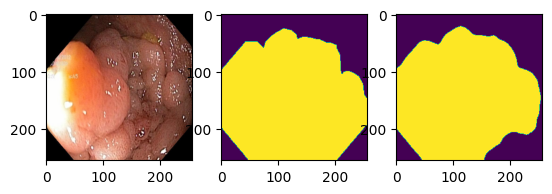

In [47]:
model.eval()
idx = random.randint(0, 100)

with torch.no_grad():
  x, y = test_dataset[idx]
  x = x.to(DEVICE).float().unsqueeze(0)
  y_hat = model(x).squeeze()
  y_hat_mask = y_hat.sigmoid().round().long()
  plt.subplot(1, 3, 1)
  plt.imshow(unorm(x.squeeze().cpu()).permute(1, 2, 0))
  plt.subplot(1, 3, 2)
  plt.imshow(y)
  plt.subplot(1, 3, 3)
  plt.imshow(y_hat_mask.cpu())

In [44]:
torch.save({
    'load_state_dict': model.state_dict(),
    'acc': test_acc_meter.avg,
    'iou': test_iou_meter.avg,
    'dice': test_iou_meter.avg,
}, 'custom_unet_with_resnet152_backboned_test_results.pth')